<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [2]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

#Load Data

In [3]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [4]:
is_r = list()
for i in df['Age rate']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)
data = [df['Description']]
short_df = pd.concat(data, axis = 1, keys = ['description'])
short_df['age rate'] = is_r
short_df.head()

,description,age rate
0,Two imprisoned men bond over a number of years...,1
1,The Godfather follows Vito Corleone Don of the...,1
2,"The lives of two mob hitmen, a boxer, a gangst...",1
3,The early life and career of Vito Corleone in ...,1
4,A thief who steals corporate secrets through t...,0


# Hyperparameters


In [ ]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=300 

####
# training:
epochs = 10 #4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 

# hparams = {
#     "batch_size": 128,
#     "cnn_filter_sizes": [128, 128, 128],
#     "cnn_kernel_sizes": [5, 5, 5],
#     "cnn_pooling_sizes": [5, 5, 40],
#     "constraint_learning_rate": 0.01,
#     "embedding_dim": 100,
#     "embedding_trainable": False,
#     "learning_rate": 0.005,
#     "max_num_words": 10000,
#     "max_sequence_length": 250
# }



# Tokenizer

In [ ]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)

t.fit_on_texts([x for x in short_df['description']])
descr_sequences = t.texts_to_sequences([x for x in np.array(short_df['description'])])
descr_sequences = tf.keras.preprocessing.sequence.pad_sequences(descr_sequences, maxlen=maxlen)
print('sequences : ',descr_sequences,'\n')
print('word_index : ',t.word_index)
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results.astype('float32')
#descr_sequences = vectorize_sequences(descr_sequences)
print(np.array(descr_sequences))

sequences :  [[   0    0    0 ...    4 2078 2079]
 [   0    0    0 ...    7   98  330]
 [   0    0    0 ...  613    5 1197]
 ...
 [   0    0    0 ... 5014    5  157]
 [   0    0    0 ... 5017    4 1287]
 [   0    0    0 ...   44  215 1808]] 

word_index :  {'a': 1, 'the': 2, 'to': 3, 'of': 4, 'and': 5, 'in': 6, 'his': 7, 'is': 8, 'an': 9, 'with': 10, 'on': 11, 'by': 12, 'for': 13, 'he': 14, 'who': 15, 'from': 16, 'as': 17, 'their': 18, 'after': 19, 'her': 20, 'that': 21, 'when': 22, 'into': 23, 'are': 24, 'must': 25, 'they': 26, 'two': 27, 'new': 28, 'life': 29, 'up': 30, 'young': 31, 'man': 32, 'him': 33, 'one': 34, 'she': 35, 'at': 36, 'world': 37, 'group': 38, 'but': 39, 'find': 40, 'while': 41, 'out': 42, 'has': 43, 'where': 44, 'family': 45, 'against': 46, 'city': 47, 'help': 48, 'it': 49, 'agent': 50, 'himself': 51, 'town': 52, 'high': 53, 'team': 54, 'old': 55, 'back': 56, 'time': 57, 'only': 58, 'finds': 59, 'woman': 60, 'save': 61, 'mysterious': 62, 'them': 63, 'which': 64, 'f

In [ ]:
print(len(t.word_index))
#with io.open(output_dir+'/tokenizer.json','w',encoding='utf-8') as f:
#    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1 
#this represents the number of words that we tokenize different from max_features but necessary for
#the definition of the dimension of the embedding space
num_categories = 1

5021


#Split data into train and test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(descr_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[   0    0    0 ...    7  267   80]
 [   0    0    0 ... 2474   69  965]
 [   0    0    0 ...  262    4 2262]
 ...
 [   0    0    0 ...    1  201 1101]
 [   0    0    0 ... 1170 1340 1548]
 [   0    0    0 ...   39 2452   89]]


In [ ]:
l = len(X_train[102])
print(l)
#print(y_train)



300


# Model and Train

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 64)           321408    
                                                                 
 flatten_2 (Flatten)         (None, 19200)             0         
                                                                 
 dense_8 (Dense)             (None, 2000)              38402000  
                                                                 
 dense_9 (Dense)             (None, 500)               1000500   
                                                                 
 dense_10 (Dense)            (None, 100)               50100     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 39,774,109
Trainable params: 39,774,109


In [ ]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [ ]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [ ]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [ ]:
#output
n_dense + 1

65

#Configure model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/10
23/23 [==============================] - 17s 697ms/step - loss: 0.7636 - accuracy: 0.5326 - val_loss: 0.6892 - val_accuracy: 0.5443
Epoch 2/10
23/23 [==============================] - 19s 847ms/step - loss: 0.6911 - accuracy: 0.5368 - val_loss: 0.7987 - val_accuracy: 0.5443
Epoch 3/10
23/23 [==============================] - 16s 707ms/step - loss: 0.6970 - accuracy: 0.5467 - val_loss: 0.7467 - val_accuracy: 0.5443
Epoch 4/10
23/23 [==============================] - 16s 706ms/step - loss: 0.6633 - accuracy: 0.5737 - val_loss: 1.4685 - val_accuracy: 0.5443
Epoch 5/10
23/23 [==============================] - 16s 708ms/step - loss: 0.3625 - accuracy: 0.8810 - val_loss: 1.4974 - val_accuracy: 0.4937
Epoch 6/10
23/23 [==============================] - 16s 688ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.6491 - val_accuracy: 0.6076
Epoch 7/10
23/23 [==============================] - 16s 701ms/step - loss: 1.2402e-04 - accuracy: 1.0000 - val_loss: 1.6105 - val_accuracy: 0.

In [ ]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 55ms/step - loss: 1.7172 - accuracy: 0.6329
Test Score: 1.717244267463684
Test Accuracy: 0.6329113841056824


# Accuracy by Label

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [ ]:
y_hat = model.predict(X_test)

In [ ]:
len(y_hat)

79

In [ ]:
y_hat[3]

array([0.92573214], dtype=float32)

In [ ]:
print(np.array(y_test)[3])

1


In [ ]:
print(type(y_hat))

<class 'numpy.ndarray'>


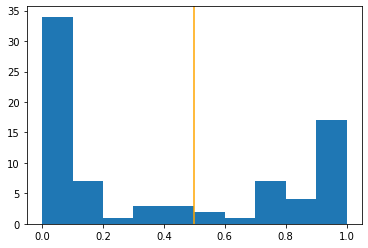

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'59.82'

In [ ]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [1]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

NameError: ignored

# Load/Save Model

In [ ]:
model.save(output_dir+'/model_v001')